Load dependencies.

In [154]:
import glob
import random
import os
from sklearn.model_selection import train_test_split
import numpy as np
from contextlib import contextmanager
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from timeit import default_timer as timer
import multiprocessing as mp
from datetime import timedelta
import pandas as pd
from scipy.spatial.distance import cosine as cosine_distance

import logging
logging.basicConfig(level=logging.INFO)

## 1. Prepare training corpus 

Since we will be training a model with hyperparameters that need to be tuned, we need a validation set along with a test set.

- **Training Dataset**: The sample of data used to fit the model.
- **Validation Dataset**: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters.
- **Test Dataset**: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

![image.png](attachment:image.png)
Image source: https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

Usually the Test set is curated to provide the gold standard, the carefully sampled data that spans the various classes that the model would face, when used in the real world. As with Kaggle, the final test set is released to the public usually only when a contest is nearing the end. However, here it is not curated, but randomly selected. It would be good in the future to have an astrophysicist carefully curate this test set to select a triplet set to test how well the model is able to detect the relationships within.

Here we randomly split our dataset into 2 — Train and Test — using the common 80:20 ratio. We set aside the Test set. We then randomly split the Train set, again using the 80:20 ratio, into the actual Train and Validation sets. We will iteratively train the model and validate it on these two sets. Then we will test the final model on the Test set. 

*Note: There is a [discussion](https://towardsdatascience.com/finally-why-we-use-an-80-20-split-for-training-and-test-data-plus-an-alternative-method-oh-yes-edc77e96295d) on how to choose best ratio. Here we just go with the conventional split, which is 80:20. But for my dissertation it may be worth looking into alternative ratios such as the scaling law, although oftentimes the increase in performance is small.*

In [2]:
# Collect all filenames
filenames = np.array(glob.glob('/Volumes/BRIENNAKH/Thesis/data/2020_06_09_abstract_tokens/*.npy'))
print('Number of abstracts: ' + str(len(filenames)))

# Randomly shuffle
print('Randomly shuffling...')
np.random.shuffle(filenames)

# Split 80:20 (we will do this part iteratively later in cross-validation)
print('Splitting files into two subsets with a ratio of 80:20...')
train_data, test_data = train_test_split(filenames, test_size=0.2)
train_data, validation_data = train_test_split(train_data, test_size=0.2)
print('Number of abstracts for training: ' + str(len(train_data)))
print('Number of abstracts for testing: ' + str(len(test_data)))
print('Number of abstracts for validation: ' + str(len(validation_data)))

Number of abstracts: 159616
Randomly shuffling...
Splitting files into two subsets with a ratio of 80:20...
Number of abstracts for training: 102153
Number of abstracts for testing: 31924
Number of abstracts for validation: 25539


## 2. Train doc2vec

To train the model, our corpus can be simply a list of documents, but since we have a large corpus, we are using an iterable that streams the documents directly from disk/network. 

In [3]:
class DocumentIterator(object):
    def load_documents(self):
        for filename in self.filenames: 
            loaded_file = np.load(filename)
            tag = os.path.splitext(os.path.basename(filename))[0]
            abstract = TaggedDocument(words=loaded_file, tags=[tag])
            try:
                yield abstract
            except Exception as e:
                print('Error!' + str(e))
            finally:
                del loaded_file
                # print('Closed ' + tag)
                
    def __init__(self, filenames):
        self.filenames = filenames
        self.documents = self.load_documents()

    def __iter__(self):
        self.generator = self.load_documents() # Reset the iterator
        return self
    
    def __next__(self):
        abstract = next(self.documents)
        return abstract

Train the model.

Parameters: 
- dm = 0 means "distributed bag of words" (PV-DBOW). dm = 1 means "distributed memory" (PV-DM)

Notes: 
- The vocabulary is a dictionary (accessible via model.wv.vocab) of all of the unique words extracted from the training corpus along with the count (e.g., model.wv.vocab['penalty'].count for counts for the word penalty).

In [5]:
start = timer()
model = Doc2Vec(DocumentIterator(train_data),
                vector_size=300,
                alpha=0.025,
                min_alpha=0.001, 
                min_count=1,
                workers=mp.cpu_count(),
                dm=1,
                epochs=40)
#model.save('d2v.model')
print('Model Saved')
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #10000, processed 2130028 words (16539/s), 30114 word types, 10000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #20000, processed 4258194 words (15906/s), 40930 word types, 20000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #30000, processed 6400029 words (17016/s), 49048 word types, 30000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #40000, processed 8525631 words (15496/s), 55860 word types, 40000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #50000, processed 10658562 words (15244/s), 61713 word types, 50000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #60000, processed 12781166 words (14471/s), 66916 word types, 60000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #70000, processed 14911706 words (14854/s), 71647 word types, 70000

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 8 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 9 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
INFO:gensim.models.base_any2vec:worker thr

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 17 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 18 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
INFO:gensim.models.base_any2vec:worker t

INFO:gensim.models.base_any2vec:EPOCH - 26 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 27 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 36 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 37 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
INFO:gensim.models.base_any2vec:worker t

Model Saved
Execution time HH:MM:SS: 0:24:24.595717


## 3. Evaluate using subdomains

From the remaining 20% papers, construct a dataset of triplets in which we randomly select 
- an anchor paper A, 
- a positively-related paper B which shares at least one author-assigned sub-subject with paper A, 
- and a negatively-related paper C which shares no sub-subjects with paper A. 

We expect papers A and B to have more similar vector representations than papers A and C, thus we will determine model accuracy as the total number of triplets where the similarity is higher between the anchor and positively related papers rather than between the anchor and negatively related papers:

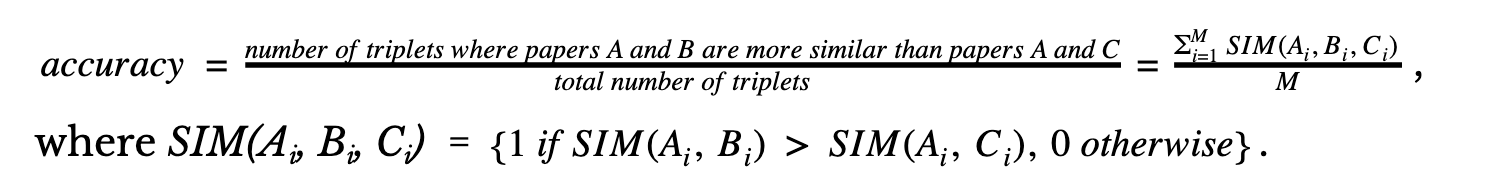

We are using the validation set to evaluate the model. Load metadata for the validation set.

In [21]:
metadata = pd.read_csv('../data/2020_03_06_arxiv_metadata_astroph/arxiv_metadata_astroph.csv',
                       dtype={'filename': str,
                              'filename_parsed': str,
                              'identifier': str,
                              'updated': str,
                              'doi': str}, 
                       parse_dates=['date_retrieved'])

validation_ids = [os.path.splitext(os.path.basename(x))[0] for x in validation_data]
validation_metadata = metadata[metadata['filename_parsed'].isin(validation_ids)]
validation_metadata

,identifier,filename,spec,title,datestamp,created,updated,authors,categories,journal,doi,abstract,comments,date_retrieved,filename_parsed
19924,oai:arXiv.org:0901.0007,0901.0007,physics:astro-ph,"Eternal Inflation, Bubble Collisions, and the ...",2009-09-28,2009-01-02,2009-06-04,"Ben Freivogel, Matthew Kleban, Alberto Nicolis...",hep-th astro-ph.CO gr-qc,"JCAP 0908:036,2009",10.1088/1475-7516/2009/08/036,We compute the probability distribution for ...,NaN,2020-03-07 02:10:36.300743,0901.0007
19956,oai:arXiv.org:0901.0202,0901.0202,physics:astro-ph,Modeling the RV and BVS of active stars,2015-05-13,2009-01-01,NaN,"Cezary Migaszewski, Grzegorz Nowak",astro-ph.SR,NaN,10.1051/eas/1042015,We present a method of modeling the radial v...,NaN,2020-03-07 02:10:36.300743,0901.0202
19957,oai:arXiv.org:0901.0215,0901.0215,physics:astro-ph,The universe as a black hole in isotropic coor...,2009-01-21,2009-01-02,NaN,Nikodem J. Poplawski,gr-qc astro-ph.CO,NaN,NaN,We show that the radial geodesic motion of a...,NaN,2020-03-07 02:10:36.300743,0901.0215
19958,oai:arXiv.org:0901.0223,0901.0223,physics:astro-ph,NLTE models of line-driven stellar winds III. ...,2009-11-13,2009-01-02,NaN,"Jiri Krticka, Jiri Kubat",astro-ph.SR,NaN,10.1111/j.1365-2966.2009.14457.x,We study the influence of X-rays on the wind...,NaN,2020-03-07 02:10:36.300743,0901.0223
19959,oai:arXiv.org:0901.0239,0901.0239,physics:astro-ph,Deep-Sea Acoustic Neutrino Detection and the A...,2019-08-13,2009-01-02,2009-04-08,Robert Lahmann,astro-ph.IM,NaN,10.1016/j.nima.2008.12.204,The use of conventional neutrino telescope m...,NaN,2020-03-07 02:10:36.300743,0901.0239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179524,oai:arXiv.org:1912.13197,1912.13197,physics:astro-ph,Nonlinear Coupling of Electromagnetic and Elec...,2020-02-19,2019-12-31,NaN,"N. L. Shatashvili, S. M. Mahajan, V. I. Berezh...",physics.plasm-ph astro-ph.SR,NaN,10.1063/1.5135959,Nonlinear wave--coupling is studied in a mul...,NaN,2020-03-07 02:10:36.300743,1912.13197
179531,oai:arXiv.org:1912.13240,1912.13240,physics:astro-ph,ALMA observations reveal no preferred outflow-...,2020-02-19,2019-12-31,NaN,"T. Baug, Ke Wang, Tie Liu, Mengyao Tang, Qizho...",astro-ph.GA,NaN,10.3847/1538-4357/ab66b6,We present a statistical study on the orient...,NaN,2020-03-07 02:10:36.300743,1912.13240
179534,oai:arXiv.org:1912.13326,1912.13326,physics:astro-ph,EFT Compatible PBHs: Effective Spawning of the...,2020-01-15,2019-12-31,NaN,"Amjad Ashoorioon, Abasalt Rostami, Javad T. Fi...",astro-ph.CO gr-qc hep-ph hep-th,NaN,NaN,Most of the inflationary scenarios that try ...,NaN,2020-03-07 02:10:36.300743,1912.13326
179549,oai:arXiv.org:2001.00085,2001.00085,physics:astro-ph,How surfaces shape the climate of habitable ex...,2020-02-19,2019-12-31,2020-02-06,"Jack Madden, Lisa Kaltenegger",astro-ph.EP astro-ph.SR,NaN,10.1093/mnras/staa387,Large ground- and space-based telescopes wil...,NaN,2020-03-07 02:10:36.300743,2001.00085


Set categories.

In [30]:
acceptable_subdomains = ['astro-ph.SR',
                         'astro-ph.CO',
                         'astro-ph.GA',
                         'astro-ph.HE',
                         'astro-ph.EP',
                         'astro-ph.IM']

Construct triplets within the validation set. 

In [183]:
validation_metadata = metadata[metadata['filename_parsed'].isin(validation_ids)]
# Randomly select anchor paper A
triplets = []
while True:
    a = validation_metadata[validation_metadata['filename_parsed'] == random.choice(validation_data_ids)]
    validation_metadata.drop(a.index, inplace=True)
    b, c = get_others(a)
    triplets.append((a, b, c))

Choosing paper B from 12809 eligible papers...
Choosing paper C from 12729 eligible papers...
Choosing paper B from 12807 eligible papers...
Choosing paper C from 12728 eligible papers...
Choosing paper B from 7882 eligible papers...
Choosing paper C from 17650 eligible papers...
Choosing paper B from 7880 eligible papers...
Choosing paper C from 17649 eligible papers...
Choosing paper B from 6507 eligible papers...
Choosing paper C from 19019 eligible papers...
Choosing paper B from 5872 eligible papers...
Choosing paper C from 19651 eligible papers...
Choosing paper B from 5870 eligible papers...
Choosing paper C from 19650 eligible papers...
Choosing paper B from 6504 eligible papers...
Choosing paper C from 19013 eligible papers...
Choosing paper B from 6320 eligible papers...
Choosing paper C from 19194 eligible papers...
Choosing paper B from 7877 eligible papers...
Choosing paper C from 17634 eligible papers...
Choosing paper B from 7875 eligible papers...
Choosing paper C from 

Choosing paper B from 6450 eligible papers...
Choosing paper C from 18824 eligible papers...
Choosing paper B from 7780 eligible papers...
Choosing paper C from 17491 eligible papers...
Choosing paper B from 6261 eligible papers...
Choosing paper C from 19007 eligible papers...
Choosing paper B from 7778 eligible papers...
Choosing paper C from 17487 eligible papers...
Choosing paper B from 12659 eligible papers...
Choosing paper C from 12603 eligible papers...
Choosing paper B from 2746 eligible papers...
Choosing paper C from 22513 eligible papers...
Choosing paper B from 7773 eligible papers...
Choosing paper C from 17483 eligible papers...
Choosing paper B from 5809 eligible papers...
Choosing paper C from 19444 eligible papers...
Choosing paper B from 7771 eligible papers...
Choosing paper C from 17479 eligible papers...
Choosing paper B from 5807 eligible papers...
Choosing paper C from 19440 eligible papers...
Choosing paper B from 5805 eligible papers...
Choosing paper C from 1

Choosing paper B from 6384 eligible papers...
Choosing paper C from 18626 eligible papers...
Choosing paper B from 5751 eligible papers...
Choosing paper C from 19256 eligible papers...
Choosing paper B from 5749 eligible papers...
Choosing paper C from 19255 eligible papers...
Choosing paper B from 2704 eligible papers...
Choosing paper C from 22297 eligible papers...
Choosing paper B from 6381 eligible papers...
Choosing paper C from 18617 eligible papers...
Choosing paper B from 7706 eligible papers...
Choosing paper C from 17289 eligible papers...
Choosing paper B from 6194 eligible papers...
Choosing paper C from 18798 eligible papers...
Choosing paper B from 5746 eligible papers...
Choosing paper C from 19243 eligible papers...
Choosing paper B from 5744 eligible papers...
Choosing paper C from 19242 eligible papers...
Choosing paper B from 7703 eligible papers...
Choosing paper C from 17280 eligible papers...
Choosing paper B from 6379 eligible papers...
Choosing paper C from 18

IndexError: single positional indexer is out-of-bounds

In [185]:
len(triplets)

190

In [180]:
def get_others(a):
    '''
    Randomly selects a positively-related paper B which shares at least one category with paper A.
    '''
    # Get Paper B
    b_indices = []
    acceptable_categories_from_a = [x for x in a['categories'].str.split(' ').iloc[0] if x in acceptable_subdomains]
    # Find all other abstracts in the validation set which share at least one of these categories.
    categories = validation_metadata['categories'].str.split(' ')
    for i, _ in enumerate(categories): # For each paper
        for j, category in enumerate(categories.iloc[i]): # For each of its categories
            if category in acceptable_categories_from_a: 
                b_indices.append(categories.keys()[i])
                break
    print('Choosing paper B from ' + str(len(b_indices)) + ' eligible papers...')
    b = validation_metadata[validation_metadata.index == random.choice(b_indices)]
    
    # Randomly select a negatively-related paper C which shares no sub-subjects with paper A. 
    c_set = validation_metadata.drop(b_indices)
    c_index = random.choice(c_set.index)
    print('Choosing paper C from ' + str(len(c_set)) + ' eligible papers...')
    c = validation_metadata[validation_metadata.index == c_index]
    validation_metadata.drop(b.index, inplace=True)
    validation_metadata.drop(c.index, inplace=True)
    
    return b, c

Calculate similarity between each paper using our model that was trained on the train set.

In [152]:
def get_vector(new_paper):
    '''Takes a Pandas row for a paper.'''
    loaded = np.load('../data/2020_06_09_abstract_tokens/' + new_paper['filename_parsed'].iloc[0] + '.npy')
    return model.infer_vector(loaded)

a_vector = get_vector(a)
b_vector = get_vector(b)
c_vector = get_vector(c)

In [157]:
ab_dist = cosine_distance(a_vector, b_vector)
print(ab_dist)
ac_dist = cosine_distance(a_vector, c_vector)
print(ac_dist)

1.0046361763961613
0.9643677771091461


In [159]:
sim = 0
total = 0
if ab_dist > ac_dist:
    sim += 1
total += 1
print(sim)

1
